In [155]:
# Making necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import random
import time
from hmmlearn import hmm
import numpy as np
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import nltk
nltk.download('words')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from abc import ABC, abstractmethod

[nltk_data] Error loading words: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [156]:
# reading the dataset
djia_dataset = pd.read_csv("DJA.csv")

In [157]:
djia_dataset = djia_dataset.dropna()

In [158]:
djia_dataset

,Date,DJIA
0,1/20/2017,19827.25
1,1/23/2017,19799.85
2,1/24/2017,19912.71
3,1/25/2017,20068.51
4,1/26/2017,20100.91
...,...,...
730,1/14/2020,28939.67
731,1/15/2020,29030.22
732,1/16/2020,29297.64
733,1/17/2020,29348.10


In [159]:
# reading the dataset
snp = pd.read_csv("SNP.csv")
snp = snp[1075:1829]
nasdaq = pd.read_csv("NASDAQCOM.csv")

Text(0, 0.5, 'Stock Close Price')

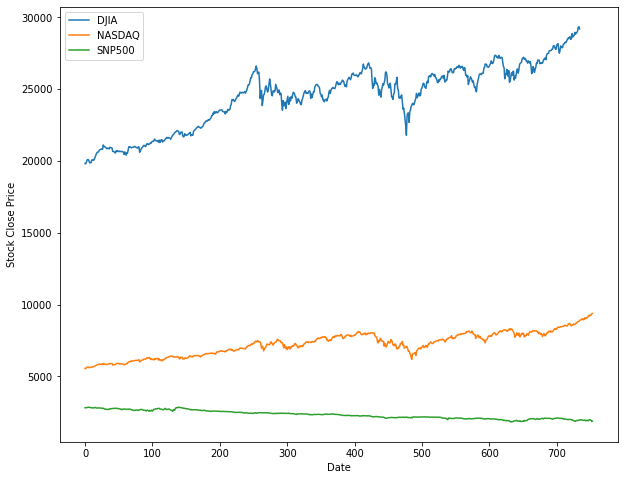

In [160]:
# Plot actual trend of data
fig = plt.figure(figsize=(10,8))
plt.plot(djia_dataset["DJIA"].tolist(), label='DJIA')
plt.plot(nasdaq["Close"].tolist(), label='NASDAQ')
plt.plot(snp["Close/Last"].tolist(), label='SNP500')
plt.legend(loc='upper left')
plt.xlabel("Date")
plt.ylabel("Stock Close Price")

In [161]:
# Function to calculate the variation
def find_variation(close_prices):
    variation = [0]
    for i in range(1, len(close_prices)):
        variation.append(((close_prices[i] - close_prices[i-1])/close_prices[i])*100)
    return variation

Text(0, 0.5, 'Variation')

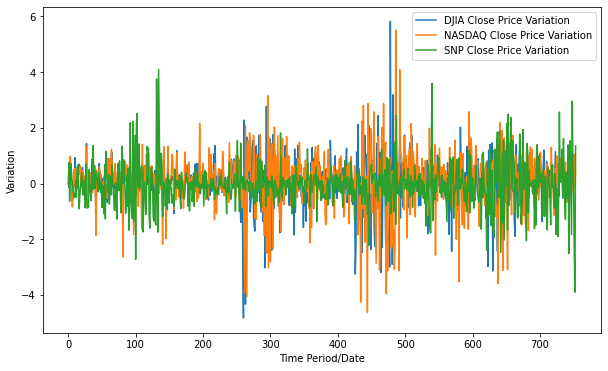

In [162]:
# Calculating and displaying variation
djia_variation = find_variation(djia_dataset["DJIA"].tolist())
snp_variation = find_variation(snp["Close/Last"].tolist())
nasdaq_variation = find_variation(nasdaq["Close"].tolist())
fig = plt.figure(figsize=(10,6))
plt.plot(djia_variation, label = 'DJIA Close Price Variation')
plt.plot(nasdaq_variation, label = 'NASDAQ Close Price Variation')
plt.plot(snp_variation, label='SNP Close Price Variation')
plt.legend(loc='upper right')
plt.xlabel('Time Period/Date')
plt.ylabel('Variation')

In [163]:
# Function to generate random transition matrix and starting probability

def generate_random_transition_matrix():
    k = 8
    result = [[random.uniform(0, 0.1 / k) for i in range(k)] for j in range(k)]
    for j, r in enumerate(result):
        r[j] += 1 - sum(r)
    return np.asarray(result)
def generate_random_start_prob():
    k = 8
    start_prob = [np.random.uniform(0,1) for _ in range(k)]
    start_prob = np.asarray(start_prob)
    start_prob = start_prob/np.sum(start_prob)
    return np.asarray(start_prob)

In [164]:
# CSP Solver
from queue import PriorityQueue
from abc import ABC, abstractmethod


class Constraint(ABC):
    def __init__(self, variables):
        self.variables = variables

    @abstractmethod
    def satisfied(self, assignment):
        pass


class CSP():
    def __init__(self, variables, domains):
        self.variables = variables
        self.domains = domains
        self.constraints = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError(
                    'Every variable should have a domain assigned to it.')

    def add_constraint(self, constraint):
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    def consistent(self, variable, assignment):
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment={}):
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment
        # get all variables in the CSP but not in the assignment
        unassigned = [v for v in self.variables if v not in assignment]
        first = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result = self.backtracking_search(local_assignment)
                if result is not None:
                    return result
        return None


class Constraint(Constraint):
    def __init__(self, place1, place2):
        super().__init__([place1, place2])
        self.place1 = place1
        self.place2 = place2

    def satisfied(self, assignment):
        if self.place1 not in assignment or self.place2 not in assignment:
            return True
        return assignment[self.place1] != assignment[self.place2]

In [165]:
# Trump Tweet Sentiment Analysis
sid = SentimentIntensityAnalyzer()
words = set(nltk.corpus.words.words())
real_donald_trump = pd.read_csv("realdonaldtrump.csv")
trump_tweets = pd.read_csv("trumptweets.csv")
cond1 = real_donald_trump['date'] >= "2017-01-20"
cond2 = real_donald_trump['date'] <= "2020-01-20"
real_donald_trump = real_donald_trump.where((cond1 & cond2)).dropna()
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet)
         if w.lower() in words or not w.isalpha())
    return tweet
    

real_donald_trump['content_clean'] = real_donald_trump['content'].apply(cleaner)
word_dict = {'manipulate':-1,'manipulative':-1,'jamescharlesiscancelled':-1,'jamescharlesisoverparty':-1,
            'pedophile':-1,'pedo':-1,'cancel':-1,'cancelled':-1,'cancel culture':0.4,'teamtati':-1,'teamjames':1,
            'teamjamescharles':1,'liar':-1,'MAGA':-1}


sid = SentimentIntensityAnalyzer()
sid.lexicon.update(word_dict)

list1 = []
for i in real_donald_trump['content_clean']:
    list1.append((sid.polarity_scores(str(i)))['compound'])
real_donald_trump['sentiment'] = list1

In [166]:
# defining a dictionary of states
states_dict = {
    0: 'very-small-rise',
    1: 'small-rise',
    2: 'large-rise',
    3: 'very-large-rise',
    4: 'very-small-drop',
    5: 'small-drop',
    6: 'large-drop',
    7: 'very-large-drop',
}

In [167]:
# Function to train HMM without CSP
def training_hmm_without_csp(training_data):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.fit(training_data)
    return model

In [168]:
# Function to train HMM with CSP
def training_hmm_with_csp(training_data, tweet_dataset):
    start_prob = generate_random_start_prob()
    transition_matrix = generate_random_transition_matrix()

    variables = [
    "0","1","2","3","4","5","6","7"
    ]
    domains = {
        "0":["0","1"],
        "1":["0","1"],
        "2":["0","1"],
        "3":["0","1"],
        "4":["0","1"],
        "5":["0","1"],
        "6":["0","1"],
        "7":["0","1"],
        "8":["0","1"],
    }
    csp = CSP(variables, domains)

    tweet_sentiment = tweet_dataset["sentiment"].tolist()
    # Adding constraints to our model
    for i in range(len(tweet_sentiment)):
        if(tweet_sentiment[i] >= 0.9): csp.add_constraint(Constraint("4","3"))
        if(tweet_sentiment[i] >= 0.6 and tweet_sentiment[i] < 0.9): csp.add_constraint(Constraint("1","2"))
        if(tweet_sentiment[i] >= 0.3 and tweet_sentiment[i] < 0.1): csp.add_constraint(Constraint("4","5"))
        else: csp.add_constraint(Constraint("6","7"))

    solution = csp.backtracking_search()
    transition_matrix = np.identity(8)
    model = hmm.GMMHMM(n_components=8, n_mix = 7, covariance_type="diag", n_iter=10)
    model.transmat_ = transition_matrix
    model.fit(training_data)

    return model
    

In [169]:
# Predict the index of states (hidden states)
def calculate_index_states(model, X_test):
    X_test = np.asarray(X_test).reshape(-1,1)
    index_states = model.predict(X_test)
    return index_states

In [170]:
# Classify the actual variation of each state (Index)
def classify_state_variation(variations):
    states = []
    for variation in variations:
        if(0 <= variation and variation < 0.1):
            states.append(0)
        elif(0.1 <= variation and variation < 1):
            states.append(1)
        elif(1 <= variation and variation < 2):
            states.append(2)
        elif(variation >= 2):
            states.append(3)
        elif(-0.1 < variation and variation <= 0):
            states.append(4)
        elif(-1 < variation and variation <= -0.1):
            states.append(5)
        elif(-2 < variation and variation <= -1):
            states.append(6)
        elif(variation <= -2):
            states.append(7)
    return states

In [171]:
# # Classify the actual variation of each state (Index)

djia_states = classify_state_variation(djia_variation)

In [172]:
# Choosing best out of 100 models with out CSP
def choose_best_model_without_csp(data):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_without_csp(X_train)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [173]:
# Choosing best out of 100 models with CSP
def choose_best_model_with_csp(data, tweet_dataset):
    X = data
    X_train = X[:int(0.8*len(X))]
    X_test = X[int(0.8*len(X)):]
    X_train = np.asarray(X_train).reshape(-1, 1)
    X_test = np.asarray(X_test).reshape(-1, 1)
    model = training_hmm_without_csp(X_train)
    best_model = model.fit(X_train)
    best_model_score = best_model.score(X_test)
    print("Model 1: Score = " + str(best_model_score))
    for i in range(2,101):
        model = training_hmm_with_csp(X_train, tweet_dataset)
        print("Model " + str(i) + ": Score = " + str(model.score(X_test)))
        if(model.score(X_test) >= best_model_score):
            best_model_score = model.score(X_test)
            best_model = model

    print("Best Model Found - Score = " + str(best_model_score))
    return best_model, best_model_score

In [174]:
# Calculate best model params and score
djia_dataset_normalized = np.asarray(djia_dataset["DJIA"].tolist())
djia_dataset_normalized = djia_dataset_normalized/sum(djia_dataset_normalized)
djia_dataset_normalized = djia_dataset_normalized.tolist()

best_model_without_csp, best_model_without_csp_score = choose_best_model_without_csp(djia_dataset_normalized)
best_model_with_csp, best_model_with_csp_score = choose_best_model_with_csp(djia_dataset_normalized, real_donald_trump)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Model 1: Score = 631.3056823204879
Model 2: Score = 529.4353496528934
Model 3: Score = 691.0078976555378
Model 4: Score = 561.5692845815104
Model 5: Score = 450.5479711380234
Model 6: Score = 520.2474089314475
Model 7: Score = 801.4372759103052
Model 8: Score = 743.8738430998566
Model 9: Score = 633.818515151551
Model 10: Score = 629.5983689175998
Model 11: Score = 677.056512337077
Model 12: Score = 735.8230851945693
Model 13: Score = 482.9947897987864
Model 14: Score = 746.0375819000685
Model 15: Score = 190.8736439268032
Model 16: Score = 736.9797608410812
Model 17: Score = 506.4540339607925
Model 18: Score = 745.7309613102648
Model 19: Score = 377.9764933557926
Model 20: Score = 723.7286305803038
Model 21: Score = 585.5789578055408
Model 22: Score = 599.3421361622121
Model 23: Score = 702.7938172265319
Model 24: Score = 571.6574801579216
Model 25: Score = 804.9153317322837
Model 26: Score = 737.7495445672806
Model 27: Score = 744.6998922602705
Model 28: Score = 740.4556901093683
Mod

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'weights_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'w'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 1: Score = 648.0085828755507


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 2: Score = 541.5620644093378


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 3: Score = 644.6291473377423


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 4: Score = 557.4137043067136


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 5: Score = 524.4370568063143


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 6: Score = 742.0385133550577


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 7: Score = 706.6881335512554


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 8: Score = 606.6722622603359


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 9: Score = 784.984647296071


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 10: Score = 566.7678629546502


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 11: Score = 512.490065317585


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 12: Score = 671.2995369521093


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 13: Score = 821.9922108869094


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 14: Score = 412.92509602801084


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 15: Score = 526.5988444752373


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 16: Score = 666.1330455578704


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 17: Score = 338.3408590115576


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 18: Score = 684.4997465882975


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 19: Score = 621.8411198176121


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 20: Score = 423.0455960677358


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 21: Score = 976.7396560844405
Model 22: Score = 637.0678271715157


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 23: Score = 710.0119776920444


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 24: Score = 603.080164298872


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 25: Score = 772.996830999411


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 26: Score = 784.0124199215592


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 27: Score = 648.336354324735


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 28: Score = 711.8414056005254
Model 29: Score = 795.0266085154564


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 30: Score = 741.5575712573066


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 31: Score = 584.401079997395


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 32: Score = 409.2990383337969


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 33: Score = 513.3046015845118


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 34: Score = 767.6290968299581


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 35: Score = 658.924598603155


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 36: Score = 602.9368032817946


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 37: Score = 813.2787459233548


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 38: Score = 751.5062811531992


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 39: Score = 961.4061936487775


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 40: Score = 751.1133256716918


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 41: Score = 687.0224156188858


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 42: Score = 731.6063667010529


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 43: Score = 722.3840915190991


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 44: Score = 712.1591371475187


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 45: Score = 526.4465198779303


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 46: Score = 647.0292698961621


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 47: Score = 695.9272115597457


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 48: Score = 689.4237066293509


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 49: Score = 736.6105342467213


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 50: Score = 678.8656953903992


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 51: Score = 718.5787281535678


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 52: Score = 704.5788595434122


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 53: Score = 629.9754405562855
Model 54: Score = 810.2521450101659


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 55: Score = 742.575906580343


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 56: Score = 848.5802921700671


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 57: Score = 647.7073549344062


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 58: Score = 571.7765447071663
Model 59: Score = 450.2259982495904


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 60: Score = 698.8142757456919


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 61: Score = 677.4278241471428


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 62: Score = 646.0626209139115


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 63: Score = 707.0586348234576


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 64: Score = 970.925806170171


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 65: Score = 747.273615572313


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 66: Score = 611.8076263282281


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 67: Score = 731.6736170217451


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 68: Score = 752.0261071193568


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 69: Score = 643.9920080236661


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 70: Score = 595.9564594456817


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 71: Score = 451.9750791683284


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 72: Score = 646.5034394326857
Model 73: Score = 742.6588481236653


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 74: Score = 709.6596481121529


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 75: Score = 748.2918724431638
Model 76: Score = 625.4251074281102


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 77: Score = 650.043305494944


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 78: Score = 651.1166398466103


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 79: Score = 798.8073616036208


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 80: Score = 601.7188954225987


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 81: Score = 248.42349275931383


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 82: Score = 674.5590035760899


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 83: Score = 647.7655511441513


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 84: Score = 561.384220115392


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 85: Score = 571.3387244815577


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 86: Score = 730.5841242155778


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 87: Score = 775.3361959172931


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 88: Score = 93.04106199393773


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 89: Score = 717.6696673065711


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 90: Score = 660.30289672005


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 91: Score = 737.0563585967718


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 92: Score = 706.8130420899669


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 93: Score = 752.7081971476395


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 94: Score = 698.8694042628082


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 95: Score = 625.4995484826187


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 96: Score = 451.24862112069036


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 97: Score = 718.8162790129765


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 98: Score = 366.78826460106427


Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


Model 99: Score = 676.2867255142538
Model 100: Score = 740.9292130636201
Best Model Found - Score = 976.7396560844405


In [175]:
# Calculate index of states
index_states_without_csp = calculate_index_states(best_model_without_csp, djia_dataset_normalized[int(0.8*len(djia_dataset_normalized)):])
index_states_with_csp = calculate_index_states(best_model_with_csp, djia_dataset_normalized[int(0.8*len(djia_dataset_normalized)):])

In [176]:
djia_states_testing = djia_states[int(0.8*len(djia_dataset_normalized)):]

In [177]:
# Count correct predictions
def correct_predictions(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        if(abs(actual_states[i] - calculated_states[i]) <= 3):
            count += 1
    return count

In [178]:
# Calculate Accuracy
accuracy_without_csp = correct_predictions(djia_states_testing, index_states_without_csp)/len(djia_states_testing)
accuracy_with_csp = correct_predictions(djia_states_testing, index_states_with_csp)/len(djia_states_testing)

In [191]:
accuracy_with_csp

0.6054421768707483

In [180]:
# Calculate MAPE
def calculate_mape(actual_states, calculated_states):
    count = 0
    for i in range(len(actual_states)):
        count = count + abs((actual_states[i] - calculated_states[i])/(actual_states[i]+100))
    return (count/len(calculated_states))*100

In [181]:
calculate_mape(djia_states_testing, index_states_with_csp)

2.756057604202851

In [182]:
# Predict Prices
def predict_prices(data, index_states):
    X = data
    price_variation = [-3,-2,-1,-0.1,0.1,1,2,3]
    predicted_prices = [X[int(0.8*len(X))-1]]
    for i in range(1, int(0.2*len(X))):
        new_price = predicted_prices[i-1] + predicted_prices[i-1]*price_variation[index_states[i]]/100
        predicted_prices.append(new_price)
    return predicted_prices    

In [183]:
predict_prices_without_csp = predict_prices(djia_dataset_normalized, index_states_without_csp)
predict_prices_with_csp = predict_prices(djia_dataset_normalized, index_states_with_csp)

Text(0.5, 1.0, 'State transition without and with CSP')

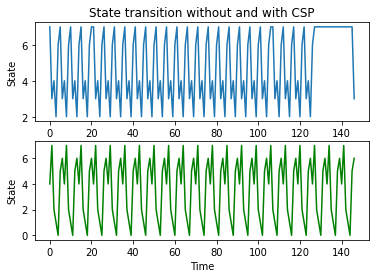

In [217]:
# State Transition
#fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots(2)
ax[0].plot(index_states_without_csp, label = 'State transition without CSP')
ax[1].plot(index_states_with_csp,label = 'State transition with CSP', color='green')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("State")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("State")
ax[0].set_title('State transition without and with CSP')

Text(0, 0.5, 'DJIA Index Value')

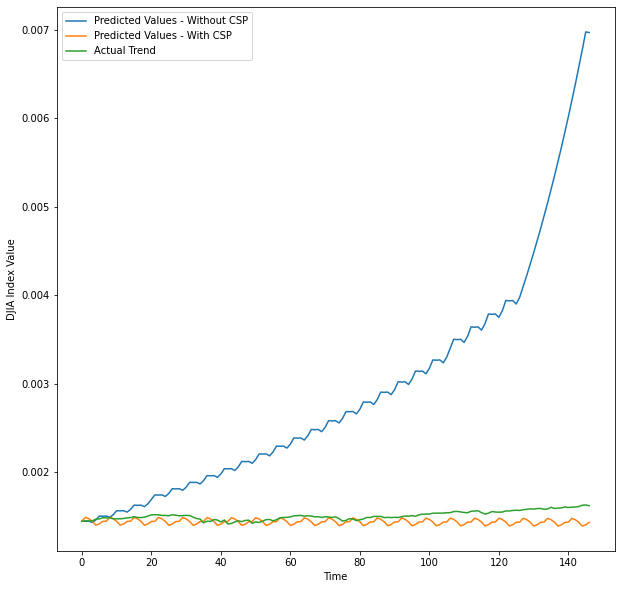

In [184]:
# plot predicted trend vs actual trend
fig = plt.figure(figsize=(10,10))
plt.plot(predict_prices_without_csp, label = 'Predicted Values - Without CSP')
plt.plot(predict_prices_with_csp, label = 'Predicted Values - With CSP')
plt.plot(djia_dataset_normalized[int(0.8*len(djia_dataset_normalized)):], label = 'Actual Trend')
plt.legend(loc = 'upper left')
plt.xlabel("Time")
plt.ylabel("DJIA Index Value")

In [185]:
#import pickle
#with open("bestfitdjiamodeln.pkl", "wb") as f: 
#    pickle.dump(best_model, f)

In [186]:
X = djia_dataset["DJIA"].tolist()
X_train = X[:int(0.8*len(X))]
X_test = X[int(0.8*len(X)):]
X_train = np.asarray(X_train).reshape(-1, 1)
X_test = np.asarray(X_test).reshape(-1, 1)

In [187]:
# Find time complexity
def finding_model_time(X_train, tweet_dataset):
    start_time = time.time()
    model = training_hmm_without_csp(X_train)
    print("--- %s seconds ---" % (time.time() - start_time))
    start_time = time.time()
    model = training_hmm_with_csp(X_train, tweet_dataset)
    print("--- %s seconds ---" % (time.time() - start_time))

In [188]:
finding_model_time(X_train, real_donald_trump)

Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'


--- 0.22924375534057617 seconds ---
--- 0.22762537002563477 seconds ---
